In [1]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])

GPU is available
GPU:  b'NVIDIA GeForce RTX 4070 SUPER'


In [2]:
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

C:\Users\cordo\AppData\Roaming\Python\Python310\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()

def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)


In [4]:
length_units = "um"
# Material parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dx=(np.sqrt(2) * total_width + link_width) / 2)
)
left_notch = right_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    # .difference(right_notch, left_notch)
    .resample(401)
    .buffer(0)
)
# Holes in the film
round_hole = (
    tdgl.Polygon("round_hole", points=circle(link_width / 2))
    .translate(dy=total_length / 5)
)
square_hole = (
    tdgl.Polygon("square_hole", points=box(link_width))
    .rotate(45)
    .translate(dy=-total_length / 5)
)
# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")

probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]


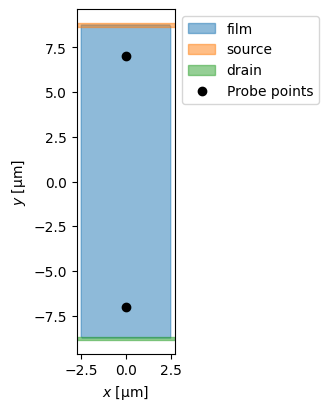

In [5]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    # holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)
fig,ax=device.draw()

In [6]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|██████████| 4931/4931 [00:02<00:00, 2004.37it/s]


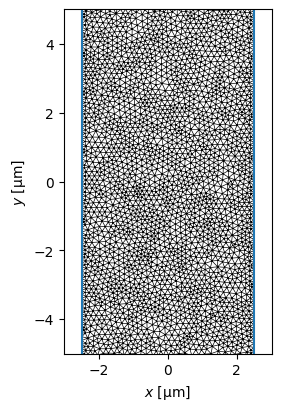

In [7]:
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)

In [8]:
device.mesh_stats()


num_sites,4931
num_elements,9460
min_edge_length,7.006e-02
max_edge_length,2.379e-01
mean_edge_length,1.459e-01
min_area,2.901e-03
max_area,3.585e-02
mean_area,1.774e-02
coherence_length,5.000e-01
length_units,um


# Corriente sin campo

In [9]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
						device,
						options,
						# terminal_currents must satisfy current conservation, i.e.,
						# sum(terminal_currents.values()) == 0.
						terminal_currents=dict(source=12, drain=-12),
					)

Simulating: 100%|██████████| 150/150 [00:04<00:00, 33.97tau/s ]


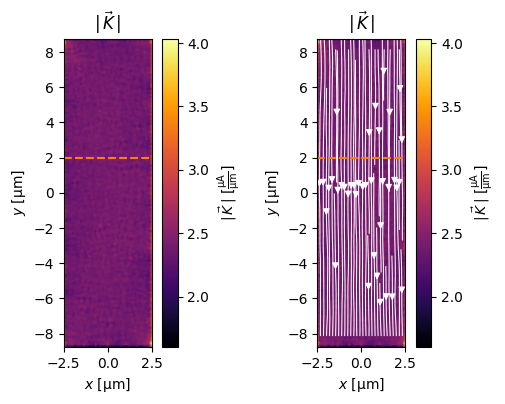

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Define the coordinates at which to evaluate the sheet current density
x = np.linspace(-total_width / 2, total_width / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "C1--")

In [11]:
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

Measured current: 12.048 µA


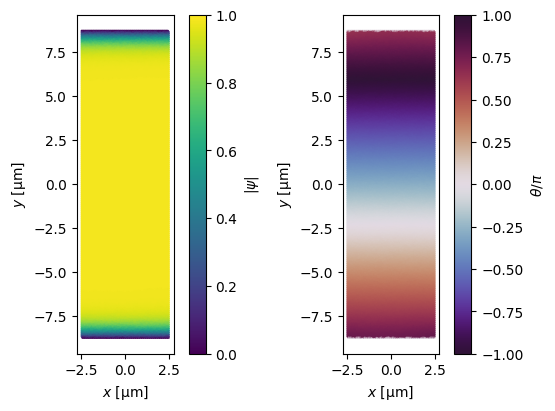

In [12]:
t0 = 112
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(5.5, 4))

In [13]:
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(zero_field_video)

# Campo Linear-Constante sin corriente

In [15]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)


RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.4

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Simulating: 100%|█████████▉| 200/200 [02:29<00:00,  1.34tau/s ]


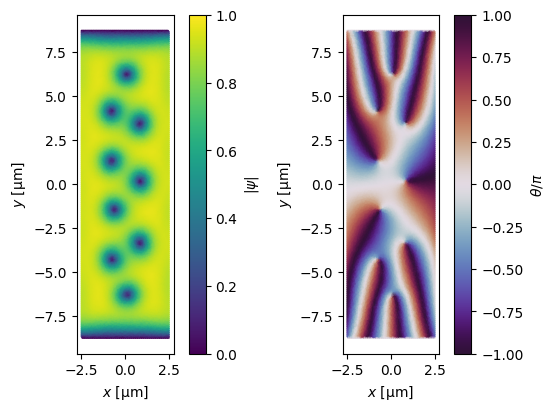

In [18]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))



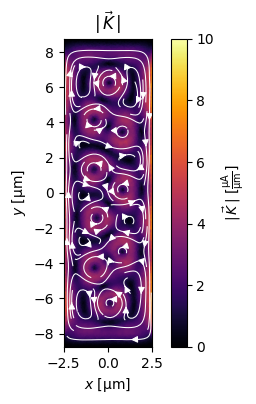

In [19]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)

# Campo y Corriente

In [ ]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
	gpu=True,
	
)


field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.4,
    terminal_currents=dict(source=12, drain=-12),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

Output file already exists. Renaming to C:\Users\cordo\AppData\Local\Temp\tmpylur0pgq\weak-link-1.h5.
Simulating:  31%|███       | 61/200 [00:29<01:06,  2.08tau/s ]


In [21]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        field_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(field_current_video)

KeyboardInterrupt: 